In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("test_hoechstgan_14yakwdx.csv")
df.describe()

,CD3+ cells,CD3 real MIR,CD3 fake MIR,CD3 relative MIR,CD8+ cells,CD8 real MIR,CD8 fake MIR,CD8 relative MIR
count,4880.000000,4801.000000,4801.000000,4800.000000,4880.000000,4081.000000,4.080000e+03,4.080000e+03
mean,4.979098,19.344376,162.573249,7.032602,3.273975,8.037556,2.613090e+03,2.008748e+02
std,4.108985,129.526402,1185.510919,46.167539,3.364046,11.148661,1.610109e+05,1.203189e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.909926e-07,3.905044e-07
25%,2.000000,8.751435,6.541234,0.598691,1.000000,4.531718,2.311813e+00,3.877389e-01
50%,4.000000,12.654789,12.321036,1.040821,2.000000,6.173827,3.641766e+00,6.481942e-01
75%,7.000000,19.643873,32.198177,2.300886,5.000000,8.803667,6.620225e+00,1.090650e+00
max,36.000000,8865.395508,42961.630000,1675.077515,28.000000,482.335327,1.028408e+07,7.683424e+05


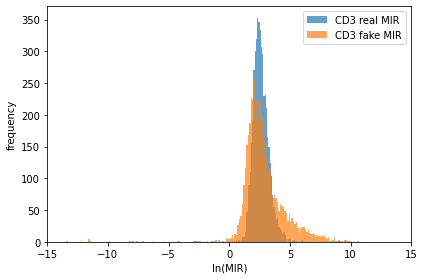

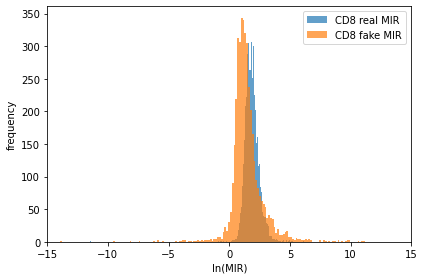

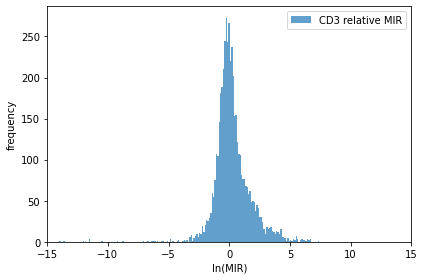

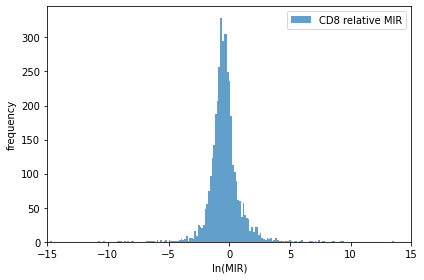

In [7]:
def plot_hist(col, color=None):
    x = np.array(df[col])
    x = x[~np.isnan(x)]
    x[x == 0] = 1e-5
    x = np.log(x)
    plt.hist(x, bins=200, alpha=.7, label=col, color=color)
    plt.xlim(-15, 15)
    plt.xlabel("ln(MIR)")
    plt.ylabel("frequency")
    plt.tight_layout()

plt.figure()
plot_hist("CD3 real MIR")
plot_hist("CD3 fake MIR")
plt.legend()
plt.savefig("mir_real_fake_cd3.png")

plt.figure()
plot_hist("CD8 real MIR")
plot_hist("CD8 fake MIR")
plt.legend()
plt.savefig("mir_real_fake_cd8.png")

plt.figure()
plot_hist("CD3 relative MIR")
plt.legend()
plt.savefig("mir_relative_cd3.png")

plt.figure()
plot_hist("CD8 relative MIR")
plt.legend()
plt.savefig("mir_relative_cd8.png")